In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
# Load the clustered data
df_labeled = pd.read_parquet('../../data/processed/clustered_data.parquet')

In [3]:
# Extract clusters and true labels
clusters = df_labeled['cluster'].to_numpy()
# Remove the cluster column to get the feature data
feature_columns = df_labeled.drop(columns=['cluster'])

In [4]:
feature_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460509 entries, 0 to 460508
Data columns (total 6 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   regione_residenza                   460509 non-null  object
 1   descrizione_attivita                460509 non-null  object
 2   tipologia_struttura_erogazione      460509 non-null  object
 3   tipologia_professionista_sanitario  460509 non-null  object
 4   fascia_eta                          460509 non-null  object
 5   incremento_teleassistenze           460509 non-null  object
dtypes: object(6)
memory usage: 21.1+ MB


In [5]:
# NOTE this is not needed, cause these columns are note used in the clustering

# Convert the datetime columns to Unix timestamp
# feature_columns['data_erogazione'] = feature_columns['data_erogazione'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
# feature_columns['data_nascita'] = feature_columns['data_nascita'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

In [6]:
# Convert non-numeric columns to numeric using LabelEncoder
for column in feature_columns.columns:
    if feature_columns[column].dtype == 'object':
        le = LabelEncoder()
        feature_columns[column] = le.fit_transform(feature_columns[column])
        
# NOTE Sarebbe meglio usare OneHotEncoder ma avendo un dataset molto grande non posso permettermi di fare one hot encoding in quanto la memoria non basta

In [7]:
# supponendo che X sia il tuo dataframe o array di feature
scaler = StandardScaler()
X_standardized = scaler.fit_transform(feature_columns)

In [8]:
X_standardized_df = pd.DataFrame(X_standardized)
print(X_standardized_df.head())

          0         1         2         3         4         5
0  0.250476 -0.308295 -1.828384 -0.086304 -0.037535 -0.602746
1  1.284751  0.515240 -1.416034 -0.086304  0.449775 -0.602746
2 -0.956180  0.412298  0.645713 -1.538514 -0.037535 -0.602746
3 -1.128559  1.184363 -1.828384  1.849977  0.449775 -0.602746
4 -1.645697  0.412298  0.645713 -1.538514  0.937085 -0.602746


In [9]:
# Function to calculate and normalize Silhouette Score
def calculate_silhouette_score(features , clusters):
    # Calculate the silhouette scores for each sample
    silhouette_vals = silhouette_samples(features, clusters)
    
    print(silhouette_vals)

    # Calculate the mean silhouette score
    # NOTE, OPTIMIZE: the code work, but the mean silhouette can be calulated in a more efficient way. "np.mean(silhouette_vals)" is enough
    # mean_silhouette = silhouette_score(features, clusters)

    # Normalize the silhouette scores to a range between 0 and 1
    normalized_silhouette_vals = (silhouette_vals - silhouette_vals.min()) / (silhouette_vals.max() - silhouette_vals.min())

    # NOTE, OPTIMIZE: the code work, but the mean silhouette can be calulated in a more efficient way. "np.mean(normalized_silhouette_vals)" is enough
    # normalized_mean_silhouette = (mean_silhouette - silhouette_vals.min()) / (silhouette_vals.max() - silhouette_vals.min())

    return normalized_silhouette_vals, silhouette_vals

In [10]:
# Calculate the normalized silhouette values
normalized_silhouette_vals, silhouette_vals = calculate_silhouette_score(X_standardized_df, clusters)  

[ 0.06012689 -0.00852486  0.01855274 ... -0.17188138  0.12656364
  0.1911706 ]


In [11]:
# Print the results
# print('Normalized Mean Silhouette Score:', normalized_mean_silhouette)
print('Normalized Silhouette Values:', normalized_silhouette_vals)

Normalized Silhouette Values: [0.62218476 0.50189498 0.54933963 ... 0.21566601 0.73859349 0.8517961 ]


In [12]:
silhouette_vals

array([ 0.06012689, -0.00852486,  0.01855274, ..., -0.17188138,
        0.12656364,  0.1911706 ])

In [13]:
np.mean(silhouette_vals)

np.float64(0.037066135194397096)

In [14]:
silhouette_vals_norm = (silhouette_vals - silhouette_vals.min()) / (silhouette_vals.max() - silhouette_vals.min())

In [15]:
np.mean(silhouette_vals_norm)

np.float64(0.5817783244970017)

In [16]:
np.mean(normalized_silhouette_vals)

np.float64(0.5817783244970017)

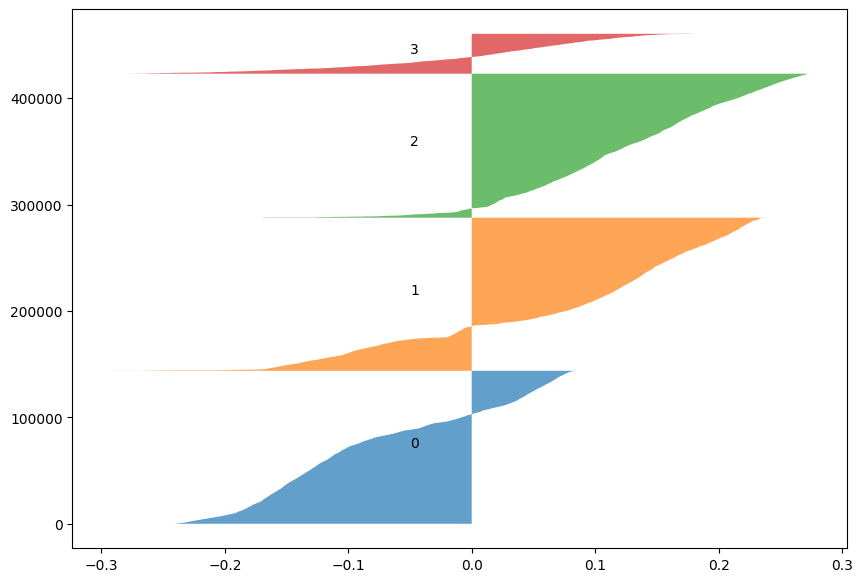

In [17]:
# Plot the silhouette values for each sample
plt.figure(figsize=(10, 7))
y_lower = 10
for i in np.unique(clusters):
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

NameError: name 'mean_silhouette' is not defined

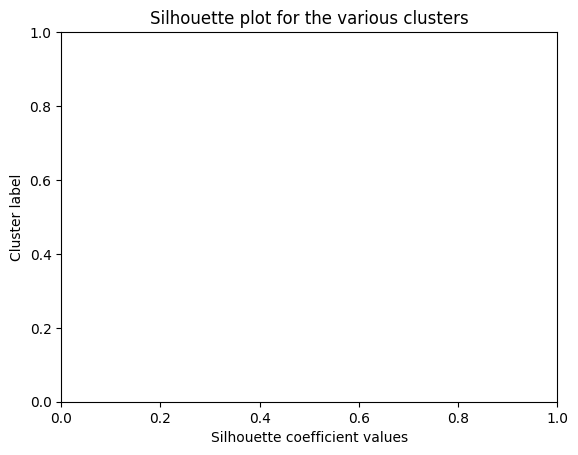

In [18]:
plt.title('Silhouette plot for the various clusters')
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster label')
plt.axvline(x=mean_silhouette, color="red", linestyle="--")
plt.yticks([])
plt.show()